# Working with Different GPModels (GPR, SVGP, GPMC, SGPMC)

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow as gf
import bnqdflow as bf
import matplotlib.pyplot as plt

gf.config.set_default_summary_fmt("notebook")

%matplotlib inline

fl = gf.utilities.to_default_float
summ = gf.utilities.print_summary

## Datset Generation

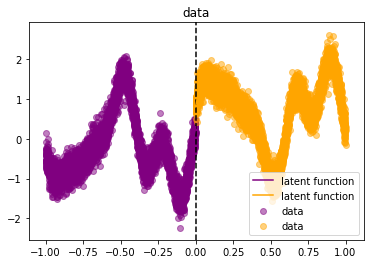

In [2]:
ip = 0  # Intervention point
dc = .5  # Discontinuity
sigma = .2  # Standard deviation
sigma_d = 0.  # Value added to the standard deviation after the intervention point
n = 10000  # Number of data points

x = np.linspace(-1, 1, n)  # Evenly distributed x values
f = lambda x: np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14) + dc * (x > ip)
y = np.random.normal(f(x), sigma + sigma_d * (x > ip), size=n)  # y values as the underlying function + noise

x1, y1 = x[x <= ip], y[x <= ip]
x2, y2 = x[x > ip], y[x > ip]

data_list = [(x1, y1), (x2, y2)]

colours = np.flip(['green', 'blue', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple'])
plt.axvline(ip, linestyle='--', c='k')
for (x, y), c in zip(data_list, colours):
    plt.plot(x, f(x), c=c, label='latent function')
    plt.scatter(x, y, c=c, alpha=0.5, label='data')
plt.title("data")
plt.legend()

## Model Specification

In [3]:
gpm_type = ['gpr', 'hmc', 'sparse', 'sparse mc'][3]

kernel = gf.kernels.RBF()
likelihood = gf.likelihoods.Gaussian()

prior = tfp.distributions.Normal
prior_mean, prior_var = 0.5, 3

prior_params = tuple(map(fl, [prior_mean, prior_var]))

gpc = bf.models.GPMContainer(
    kernel,
    data_list,
    likelihood=likelihood,
    gpm_type=gpm_type,
    intervention_points=[ip],
    n_inducing_vars=fl(0.01)
)

gpc.kernel.variance.prior = prior(*prior_params)
gpc.kernel.lengthscales.prior = prior(*prior_params)
gpc.likelihood.variance.prior = prior(*prior_params)

summ(gpc)

name,class,transform,prior,trainable,shape,dtype,value
GPMContainer.models[0].kernel.variance GPMContainer.models[1].kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPMContainer.models[0].kernel.lengthscales GPMContainer.models[1].kernel.lengthscales,Parameter,Softplus,Normal,True,(),float64,1.0
GPMContainer.models[0].likelihood.variance GPMContainer.models[1].likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,1.0
GPMContainer.models[0].inducing_variable.Z,Parameter,,,False,"(50, 1)",float64,[[-0.45394539...
GPMContainer.models[0].V,Parameter,,Normal,True,"(50, 1)",float64,[[0....
GPMContainer.models[1].inducing_variable.Z,Parameter,,,False,"(50, 1)",float64,[[8.00180018e-01...
GPMContainer.models[1].V,Parameter,,Normal,True,"(50, 1)",float64,[[0....


## Training via MAP/ML Estimate

progress: 100% | loss variance: 24.199269897


name,class,transform,prior,trainable,shape,dtype,value
GPMContainer.models[0].kernel.variance GPMContainer.models[1].kernel.variance,Parameter,Softplus,Normal,True,(),float64,0.9871982134320766
GPMContainer.models[0].kernel.lengthscales GPMContainer.models[1].kernel.lengthscales,Parameter,Softplus,Normal,True,(),float64,0.09578676698315255
GPMContainer.models[0].likelihood.variance GPMContainer.models[1].likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.038574865757200205
GPMContainer.models[0].inducing_variable.Z,Parameter,,,False,"(50, 1)",float64,[[-0.45394539...
GPMContainer.models[0].V,Parameter,,Normal,True,"(50, 1)",float64,[[1.43784251e+00...
GPMContainer.models[1].inducing_variable.Z,Parameter,,,False,"(50, 1)",float64,[[8.00180018e-01...
GPMContainer.models[1].V,Parameter,,Normal,True,"(50, 1)",float64,[[0.74235813...


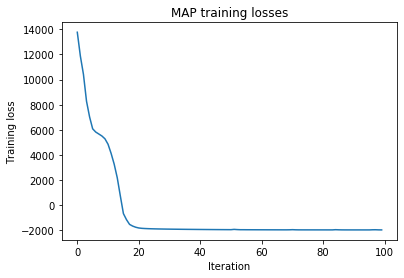

In [4]:
loss_variance_goal = 10

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)
#optimizer = gf.optimizers.Scipy()

losses = gpc.train(optimizer=optimizer, loss_variance_goal=loss_variance_goal)

if len(losses) > 0:
    plt.plot(losses)
    plt.title("MAP training losses")
    plt.xlabel("Iteration")
    plt.ylabel("Training loss")

summ(gpc)

## Sampling the Posterior Hyper-parameter Distribution

In [5]:
compatible_gpms = (gf.models.GPR, gf.models.GPMC, gf.models.SGPMC)

if isinstance(gpc.models[0], compatible_gpms):
    gpc.sample_posterior_params()
    
else:
    print(f"{gpc.models[0].__class__.__name__} does not support posterior hyper-parameter sampling")
    

In [6]:
param_to_name = {param: name for name, param in gf.utilities.parameter_dict(gpc).items()}
params = gpc.trainable_parameters
samples, _ = gpc.posterior_sampling_results
compatible = [len(tf.shape(tf.squeeze(p.numpy()))) == 0 for p in params]
params = [p for c, p in zip(compatible, params) if c]
samples = [s for c, s in zip(compatible, samples) if c]

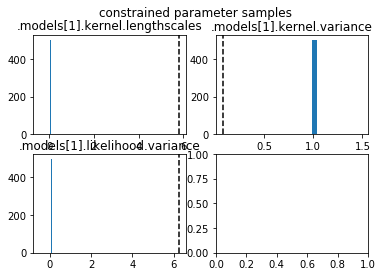

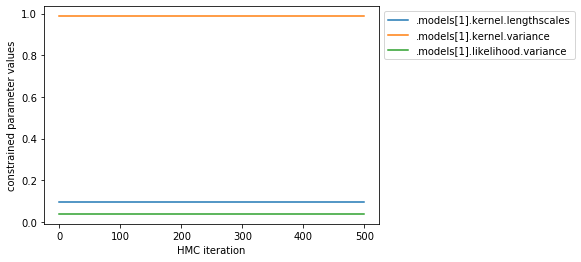

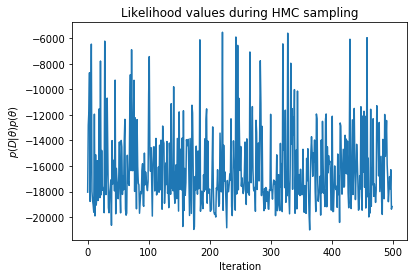

In [7]:
gpc.plot_posterior_param_samples('marginal')
plt.show()

gpc.plot_posterior_param_samples('sequence')
plt.show()

plt.plot(gpc.posterior_sampling_results[1])
plt.title("Likelihood values during HMC sampling")
plt.xlabel("Iteration")
plt.ylabel(r"$p(D|\theta)p(\theta)$")
plt.show()

## Plotting the Posterior GP Regression

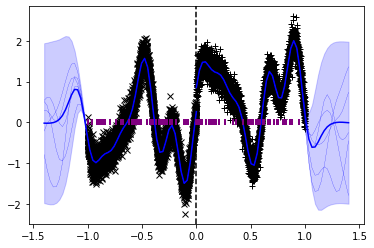

In [8]:
gpc.plot_regression()